In [46]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional

DATA_PATH = pathlib.Path("C:/Ahsan.docx/PROJECT/MetroPT_project/MetroPT/")
df = pd.read_feather(DATA_PATH / "Classification.feather")

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10773588 entries, 0 to 10773587
Data columns (total 18 columns):
 #   Column           Dtype         
---  ------           -----         
 0   timestamp        datetime64[ns]
 1   TP2              float16       
 2   TP3              float16       
 3   H1               float16       
 4   DV_pressure      float16       
 5   Reservoirs       float16       
 6   Oil_temperature  float16       
 7   Flowmeter        float16       
 8   Motor_current    float16       
 9   COMP             bool          
 10  DV_eletric       bool          
 11  Towers           bool          
 12  MPG              bool          
 13  LPS              bool          
 14  Oil_level        bool          
 15  Caudal_impulses  bool          
 16  gpsSpeed         int16         
 17  Target           int64         
dtypes: bool(7), datetime64[ns](1), float16(8), int16(1), int64(1)
memory usage: 421.3 MB
None


# Correlation matrix

In [48]:
corrs = df.drop(columns=["timestamp"]).corr()

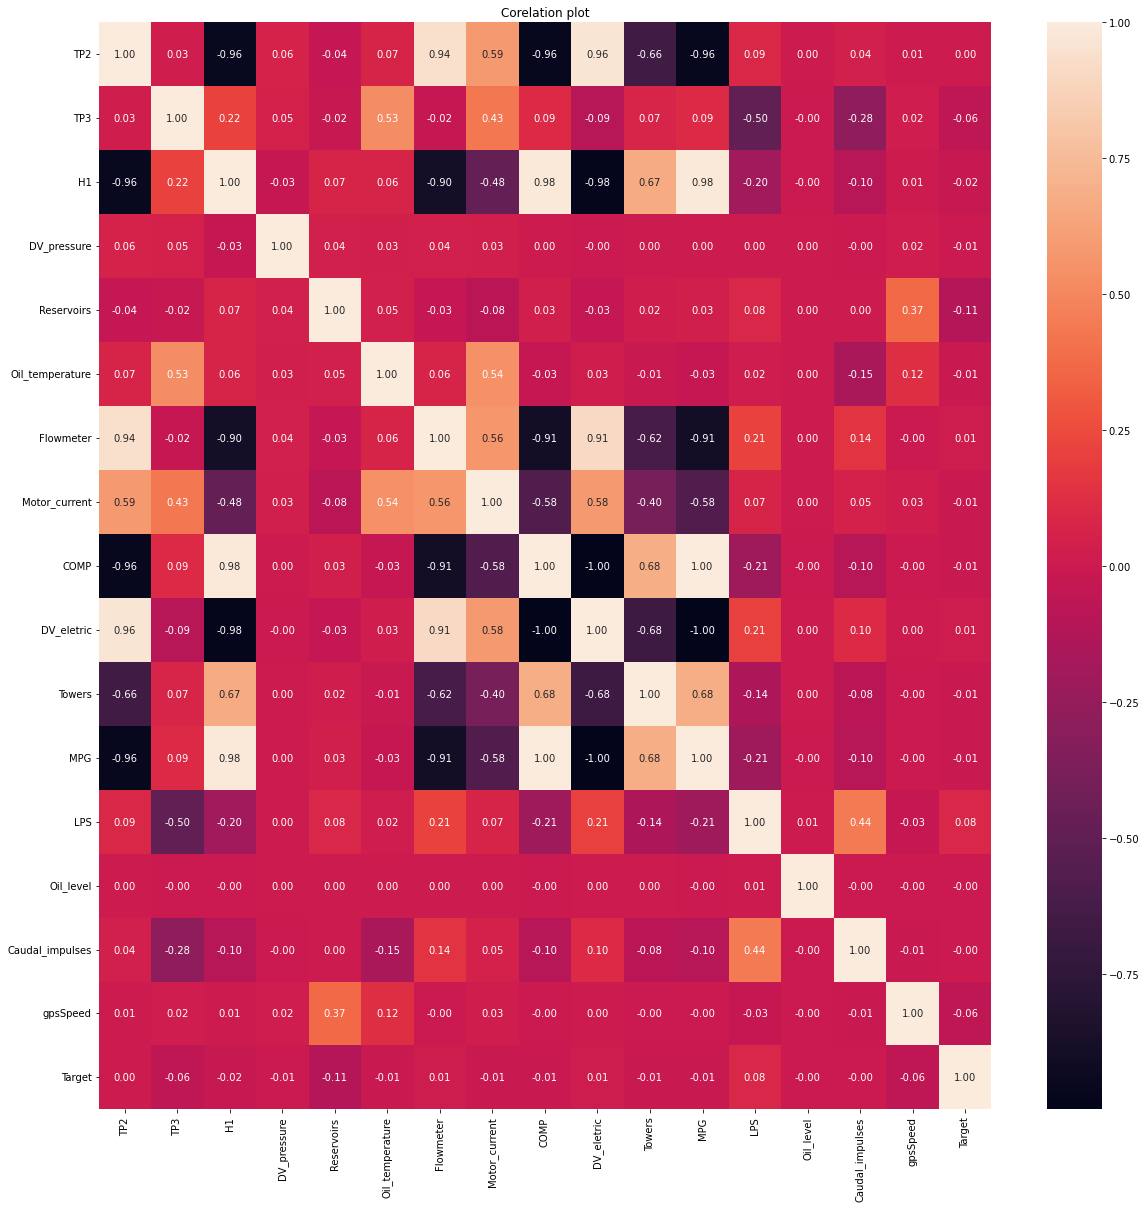

In [49]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(corrs, annot=True, fmt=".2f")
plt.title("Corelation plot")
plt.show()

In [27]:
failure_periods = [
    ("2022-02-28 21:53", "2022-03-01 02:00"),
    ("2022-03-23 14:54", "2022-03-23 15:24"),
    ("2022-05-30 12:00", "2022-06-02 06:18"),
]

failure_periods = [
    (pd.to_datetime(start), pd.to_datetime(end)) for start, end in failure_periods
]
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Looking at the first failure instance
Plot a graph of including 3hrs before failure and after color each point according to their label
check the distribution of each column in failure, normal and pre-failure
Look at the correlations


In [57]:
def plot_pre_failure(
    df: pd.DataFrame,
    start: pd.Timestamp,
    n_hours: int,
    save_path: Optional[pathlib.Path],
) -> None:
    delta: pd.Timedelta = pd.Timedelta(hours=n_hours)
    mask = (df["timestamp"] >= start - delta) & (df["timestamp"] <= start + delta)

    plot_df = df.loc[mask, :]
    columns = plot_df.select_dtypes(include=["float16", "int16", "int"]).columns

    fig, ax = plt.subplots(nrows=len(columns) - 1, ncols=1, figsize=(15, 50))
    fig.tight_layout(pad=3)
    colours = ["#0fdb60", "#f0b940", "#f6005b"]

    for i, col in enumerate(columns[:-1]):
        sns.lineplot(
            data=plot_df, x="timestamp", y=col, hue="Target", ax=ax[i], palette=colours
        )
        ax[i].set_title(col)
        ax[i].grid(True)

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)

# Convert the 'timestamp' column to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [51]:
OUT_PATH = pathlib.Path("C:/Ahsan.docx/PROJECT/MetroPT_project/MetroPT")

if not OUT_PATH.exists():
    OUT_PATH.mkdir()

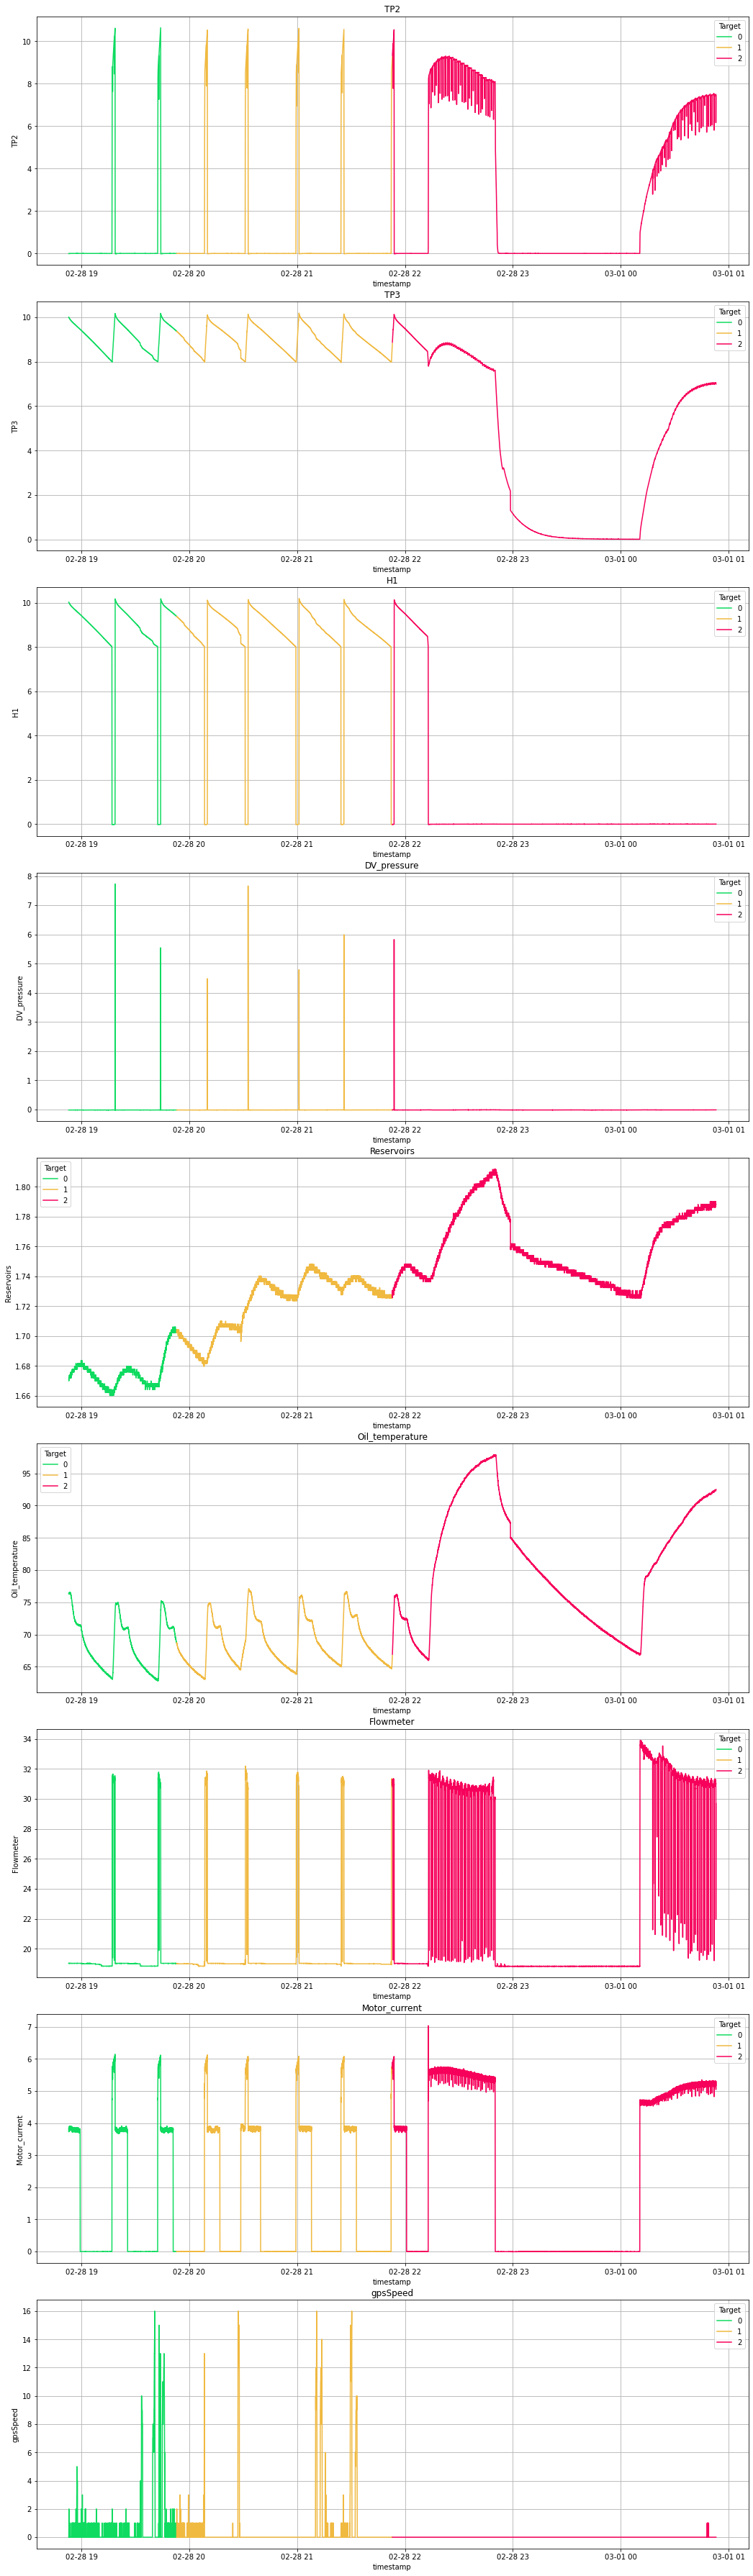

In [58]:
start = failure_periods[0][0]
plot_pre_failure(df, start, 3, OUT_PATH / "Failure_1.svg")

It looks like Resevoirs column is slightly indicating of prefailure conditions, there seems to be a rise in the value before an actual failure this is a good sign as the network maybe network maybe able to pick up on that, the other columns seem fairly normal before failure, oil temperature seems to have a slight increasing trend and seems to sky rocket after a leak, this might be interesting in a rule based approach

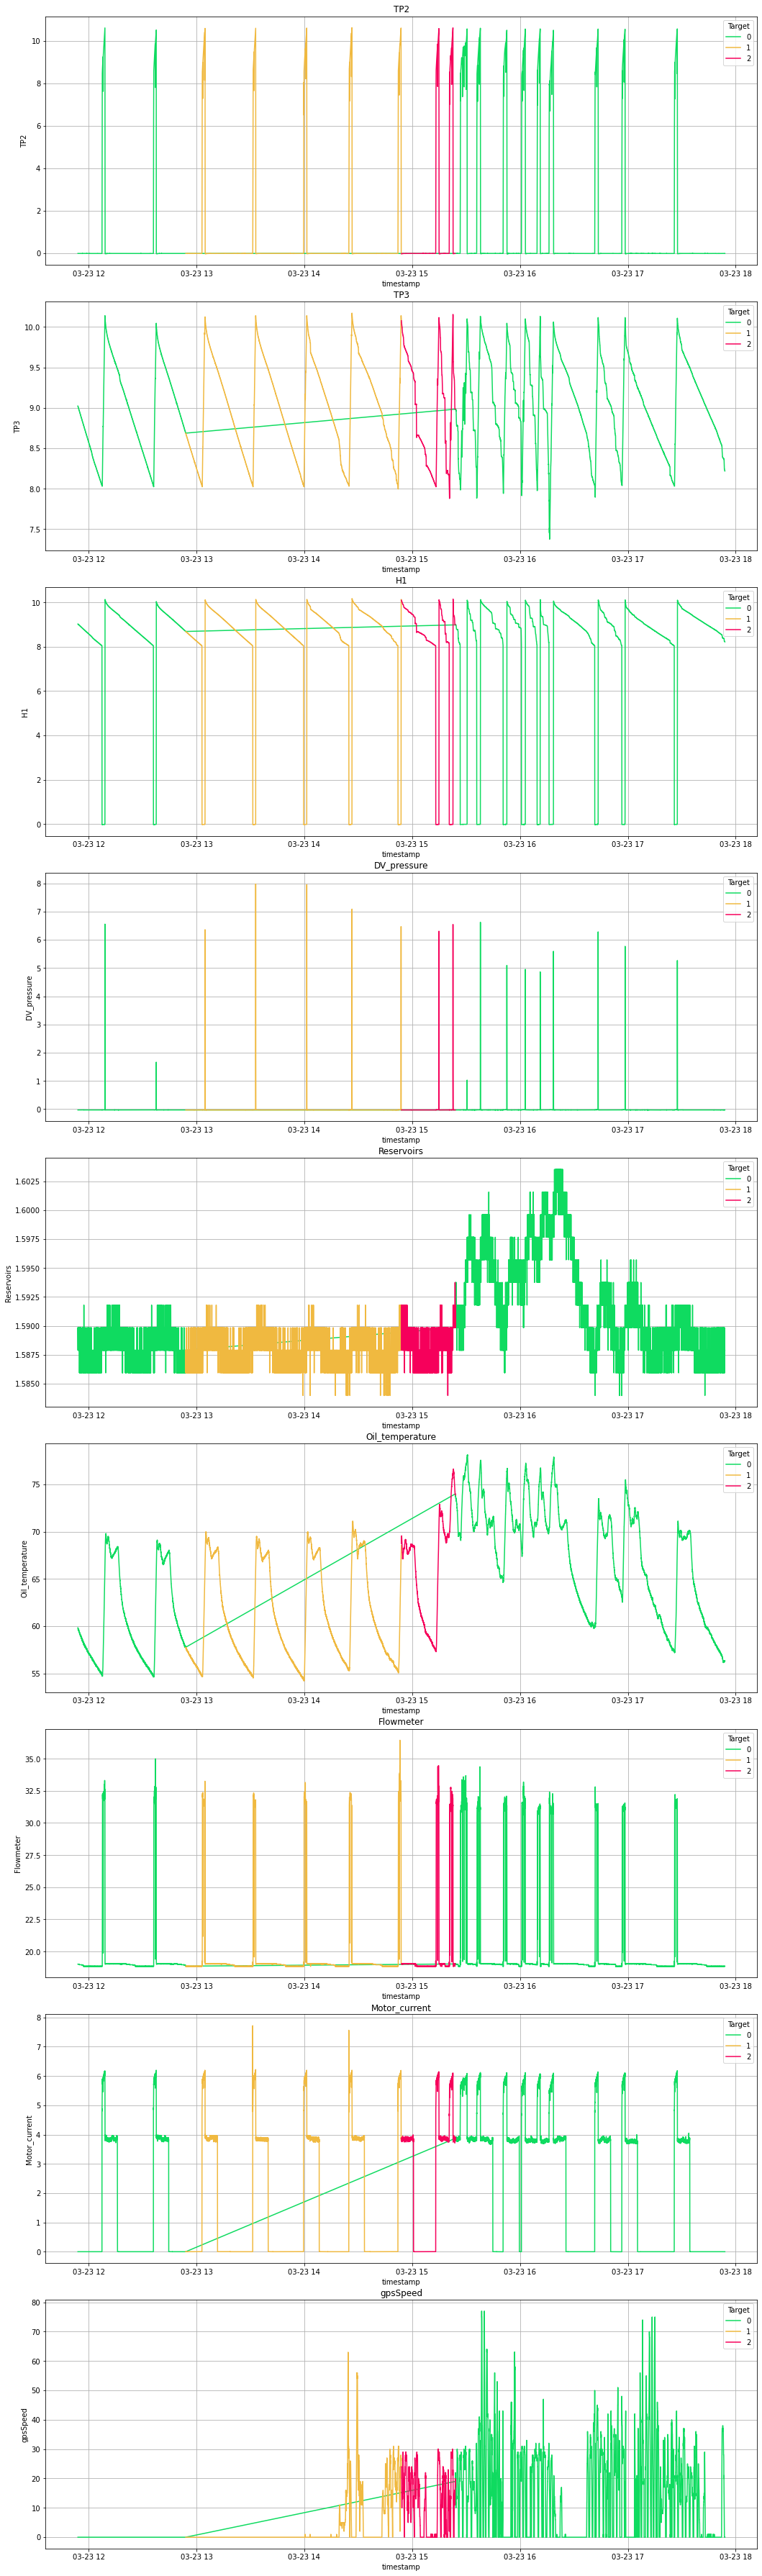

In [59]:
start = failure_periods[1][0]
plot_pre_failure(df, start, 3, OUT_PATH / "Failure_2.svg")

Once again it seems that the oil temperatures increase very slightly before a failure on the APU, the valve pressure DV_Pressure is also slightly higher than normal, motor current seems to have these abnormal spikes in between in failure 2, However it seems that failure 2 will be hard for the model to detect

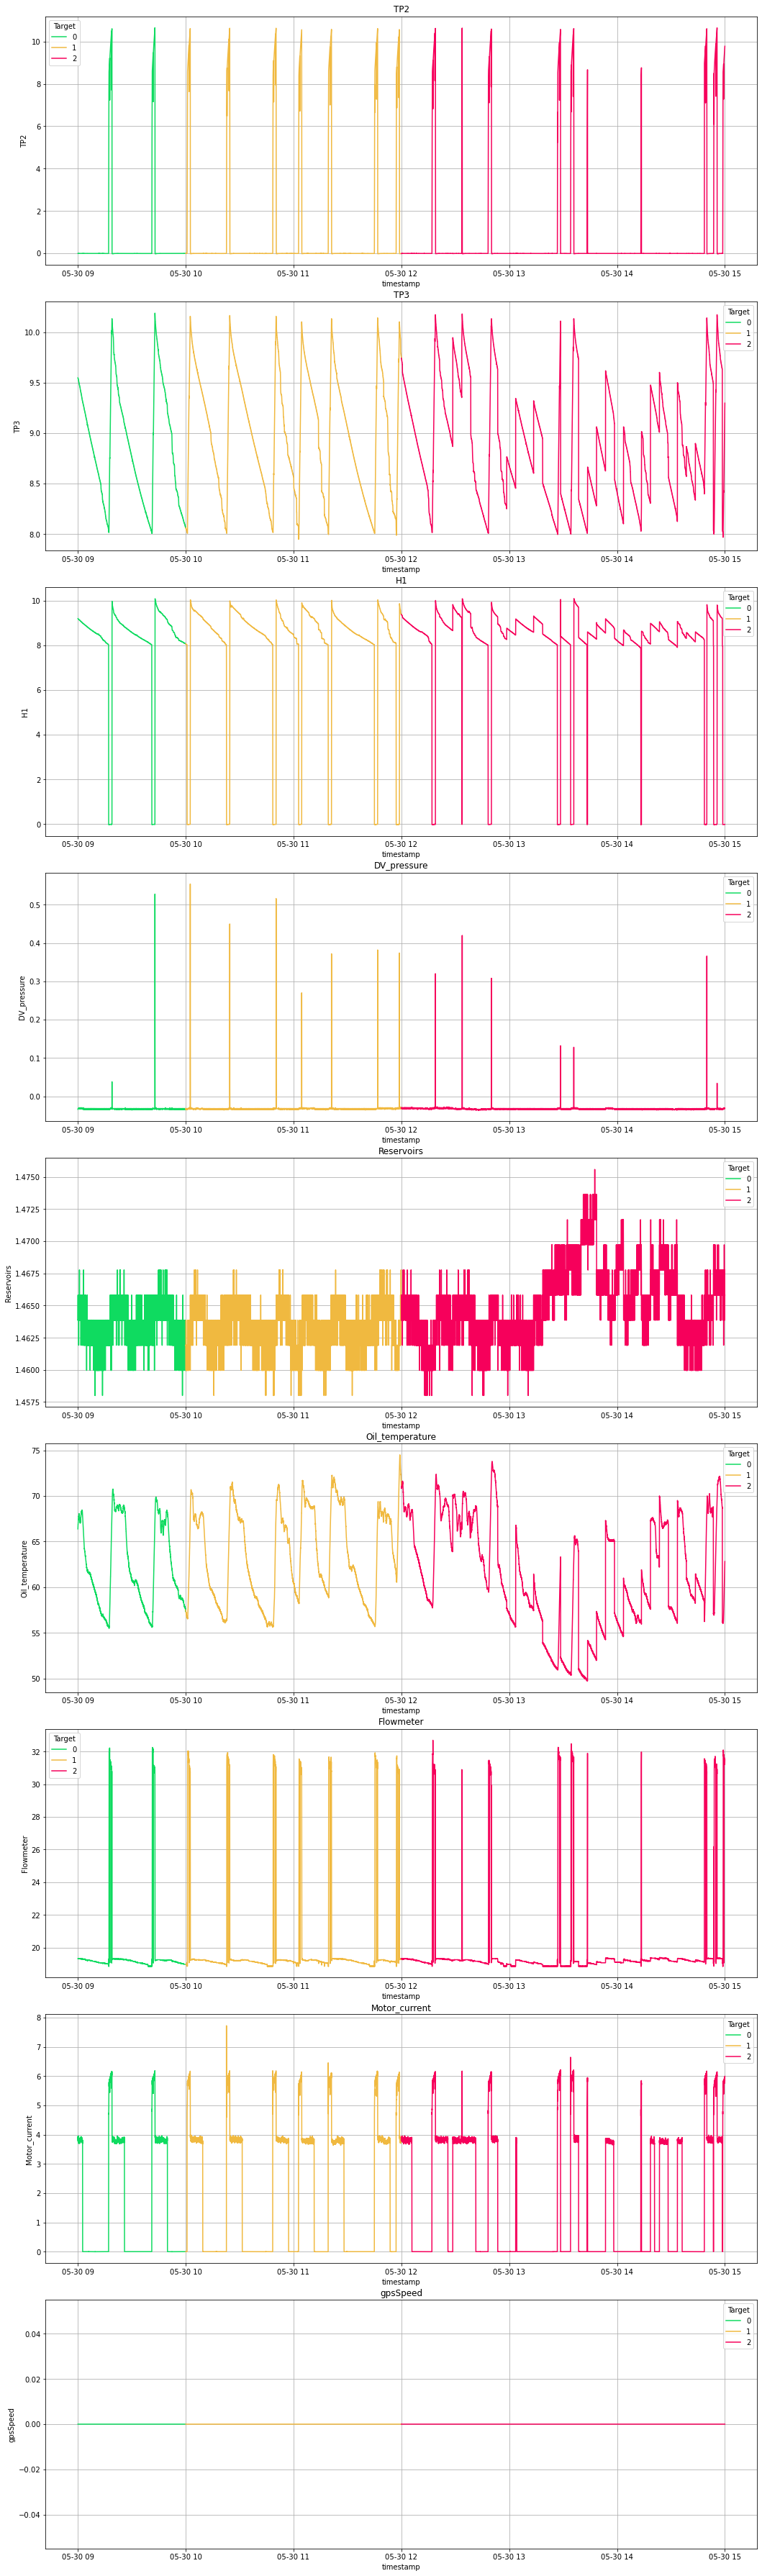

In [60]:
start = failure_periods[2][0]
plot_pre_failure(df, start, 3, OUT_PATH / "Failure_3.svg")

Oil Temperature seems to be on the rise again before a failure indicating that this is the most important thing when it comes to indicating failures, speed interesting is all 0 this means that this issue was detected when the train was not functional, I think that speed can be removed safely as it doesn't indicate that anything before a failure, however if this is actually the case then the model will just assign a low weight atleast it should, ideally.

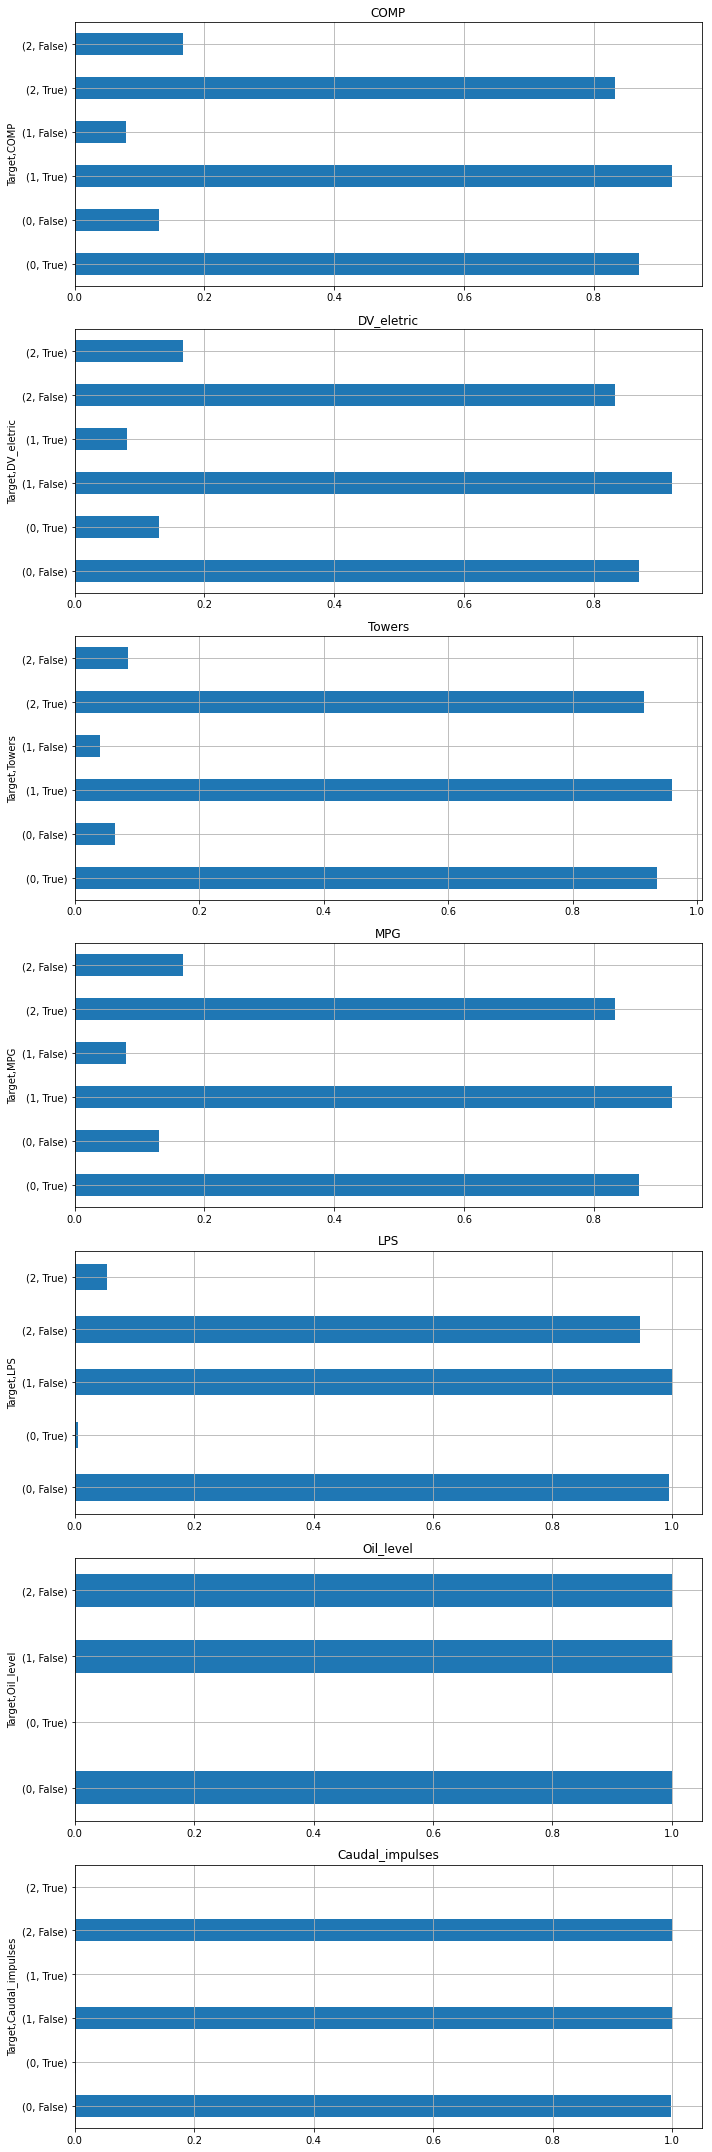

<Figure size 432x288 with 0 Axes>

In [61]:
cols = df.select_dtypes(include=["bool", "int"]).columns

# Check if there are enough columns to plot
if len(cols) > 1:
    fig, ax = plt.subplots(nrows=len(cols) - 1, ncols=1, figsize=(10, 30))
    
    for i, col in enumerate(cols[:-1]):
        df.groupby("Target")[col].value_counts(normalize=True).plot(kind="barh", ax=ax[i])
        ax[i].grid(True)
        ax[i].set_title(col)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(OUT_PATH / "Binary Vars Distribution.svg")
else:
    print("Not enough columns to plot. Need at least two numeric columns.")

The binary variables are a bit more indicative of failures this is a good sign, the MPG is mostly true before a failure, thus observing this for a long time may help... Similar thing can be said about the DV Electric, LPS is never true before a failure, so if we find the LPS to be true in even one instance in a sequence, it's like not pre failure, most likely to be a failure...

Caudal Impulses is always false, it maybe worth removing it when creating a model, same with Oil Level